# 4. 近似反向传播学习

## 4.1 SuperSpike(supervised learning rule for spiking neurons)法

在线监督学习，与 **SpikeProp**同样将Spike列作为监督信号。

与SpikeProp的不同点为，不使用spike的微分，而是函数的微分。于是即使未发火也可进行学习。

### 4.1.1 损失函数近似

$i$-th神经元的监督信号的Spike列$\hat S_i$向输出$S_i$近似:

$S_i(t)=\sum_{t_k<t} \delta(t-t_i^k)$

SpikeProp法使用的是二乘误差。

SuperSpike使用与二重指数函数filter $\alpha$卷积后的二乘误差：

$$L(t)=\frac{1}{2}\int_{-\infty}^t ds[(\alpha*\hat S_{i}-\alpha * S_i)(s)]^2$$

这也被称为 **van Rossum distance**

对于j-th前神经元到i-th后神经元的权重$w_{ij}$微分：

$$\frac{\partial L}{\partial w_{ij}}=-\int_{-\infty}^t ds [(\alpha * \hat S_i-\alpha*S_i)(s)](\alpha*\frac{\partial S_i}{\partial w_{ij}})(s)$$

目标为计算$\frac{\partial L}{\partial w_{ij}}$。

由SGD法更新权重：

$w_{ij}\leftarrow w_{ij}-r\frac{\partial L}{\partial w_{ij}}$

问题在于$\frac{\partial S_i}{\partial w_{ij}}$的部分, 由于含有$\delta$函数, 微分之后发火时为$\infty$, 未发火状态下为$0$。无法进行学习。

于是将$S_i(t)$使用LIF膜电位$U_i(t)$的非线性函数$\sigma(U_i(t))$近似。

使用的是fast sigmoid: $sigma(x)=x/(1+|x|)$

于是

$$\frac{\partial S_i}{\partial w_{ij}}\approx \frac{\partial \sigma(U_i)}{\partial w_{ij}}=\sigma'(U_i)\frac{\partial U_i}{\partial w_{ij}}$$

$$\sigma'(U_i)=(1+|\beta (U_i-ϑ)|)^{-2}$$

$ϑ$:神经元发火阈值. $-50\;mV$ 

$\beta$: $(1 mV)^{-1}$

$\frac{\partial U_i}{\partial w_{ij}}\approx \epsilon *S_j(t)$: 

$S_j(t)$给予i-th后细胞膜电位变化的影响变化。$\epsilon$ 为与 $\alpha$相同的二重指数函数filter。

也可解释为突触上神经传递物质浓度。

$t$时刻突触强度变化率$\frac{\partial w_{ij}}{\partial t}$

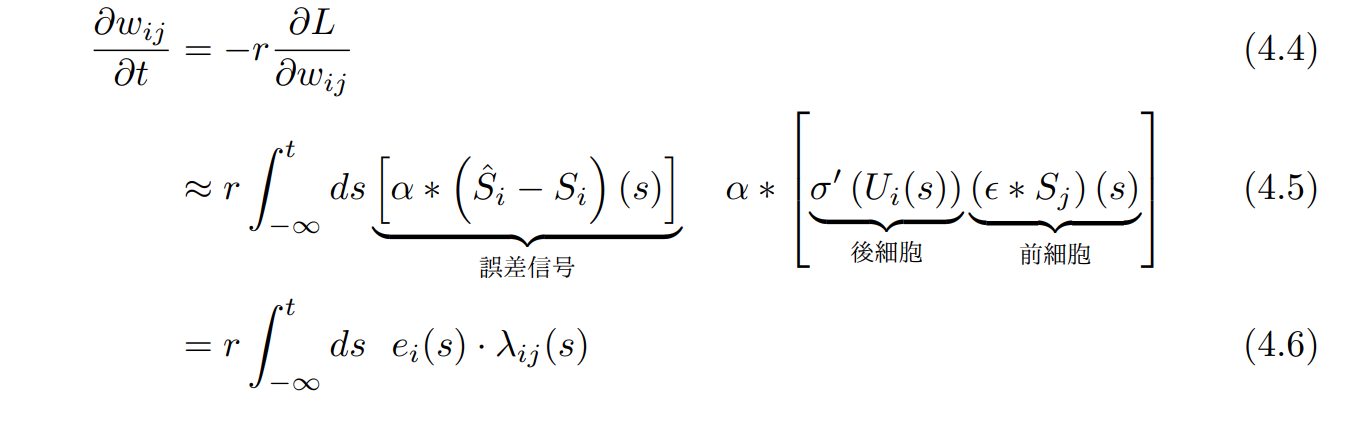

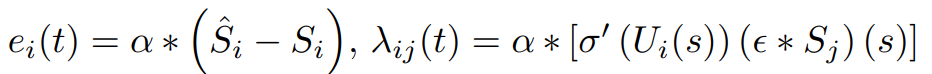

$e_i(t)$为误差信号, $\lambda_{ij}$为**synaptic eligibility trace**

### 4.1.2 离散化权重更新与RMaxProp

$$\Delta w_{ij}^k=r_{ij}\int_{t_k}^{t_{k+1}}e_i(s)\lambda_{ij}(s)ds$$

$r_{ij}$: $w_{ij}$的学习率

在实现时设$t_b:=t_{k+1}-t_k（=0.5s）$，将以0初始化的数组$[m_{ij}]$, 在每个模拟step:

$$m_{ij}\leftarrow m_{ij}+g_{ij}$$

$$g_{ij}=e_i(t)\lambda_{ij}$$

经过$t_b$之后:

$$w_{ij}=w_{ij}+r_{ij}m_{ij}\cdot \Delta t$$

之后将$m_{ij}$ reset为0。需要注意的是，更新时权重$-1<w_{ij}<1$

对于所有权重$w_{ij}$使用同样的学习率也能够进行学习过程。但该学习过程是不安定的。

于是存在一种类似ANN的RMSprop的近似Optimizer:

首先引入新的数组 $v_{ij}\leftarrow max(\gamma v_{ij},g_{ij}^2)$

$\gamma$为超参数。无详细记载。但实践中值0.8左右是是优良的。

学习率定义为$r_{ij}=\frac{r_0}{\sqrt{v_{ij}}+\epsilon}$, 其中$r_0$为学习系数, $\epsilon$为一个小值（典型为$1e-8$）。

同时还存在 **learning rate decay**的策略。


RMSprop中$v_{ij}$变化式子为$v_{ij}\leftarrow \gamma v_{ij}+(1-\gamma)\cdot g_{ij}^2$

### 4.1.3 关于误差信号传播

在输出层上计算误差$e_i(t)=\alpha * (\hat S_i - S_i)$, 搬运到低层。

考虑将层$l$的k-th神经元误差$e_k$搬运至层$l-1$的i-th神经元。

对于对称的feedback的情况，准备$W=[w_{ik}]$的转置$W^T=[w_{ki}]$

$$e_i=\sum_k w_{ki}e_{k}$$

但是在生物学上，这样对称的方式是不妥当的。

为了解决使用对称权重的问题，存在 **Feedback alignment**策略。

**Feedback alignment**下在误差传播时，将权重随机固定。

将随机固定的权重设为$B=[b_{ki}]$

Feedback alignment的情况下

$$e_i=\sum_k b_{ki}e_k$$

也存在权重均一的学习方式(Uniform feedback):

$$e_i=\sum_k e_k$$

### 4.1.4 SuperSpike法实现

In [38]:
import numpy as np
from Models.Neurons import CurrentBasedLIF
from Models.Synapses import DoubleExponentialSynapse
from Models.Connections import FullConnection, DelayConnection

In [39]:
class ErrorSignal:
    def __init__(self, N, dt=1e-4, td=1e-2, tr=5e-3):
        self.dt = dt
        self.td = td
        self.tr = tr

        self.N = N
        self.r = np.zeros(N)
        self.hr = np.zeros(N)
        self.b = (td/tr)**(td/(tr-td)) # 規格化定数
    def initialize_states(self):
        self.r = np.zeros(self.N)
        self.hr = np.zeros(self.N)
    def __call__(self, output_spike, target_spike):
        r = self.r*(1-self.dt/self.tr) + self.hr/self.td*self.dt
        hr = self.hr*(1-self.dt/self.td)+(target_spike-output_spike)/self.b
        self.r = r
        self.hr = hr
        return r


In [40]:
class EligibilityTrace:
    def __init__(self, N_in, N_out, dt=1e-4, td=1e-2, tr=5e-3):
        self.dt = dt
        self.td = td
        self.tr = tr
        self.N_in = N_in
        self.N_out = N_out
        self.r = np.zeros((N_out, N_in))
        self.hr = np.zeros((N_out, N_in))

    def initialize_states(self):
        self.r = np.zeros((self.N_out, self.N_in))
        self.hr = np.zeros((self.N_out, self.N_in))

    def surrogate_derivative_fastsigmoid(self, u, beta=1, vthr=-50):
        return 1 / (1 + np.abs(beta*(u-vthr)))**2
    
    def __call__(self, pre_current, post_voltage):
        # (N_out, 1) x (1, N_in) -> (N_out, N_in)
        pre_ = np.expand_dims(pre_current, axis=0)
        post_ = np.expand_dims(self.surrogate_derivative_fastsigmoid(post_voltage),axis=1)
        r = self.r*(1-self.dt/self.tr) + self.hr*self.dt
        hr = self.hr*(1-self.dt/self.td)+np.dot(post_,pre_)/(self.tr*self.td)
        self.r = r
        self.hr = hr
        return r

In [42]:

dt = 1e-4; T = 0.5; nt = round(T/dt)
t_weight_update = 0.5 #重みの更新時間
nt_b = round(t_weight_update/dt) #重みの更新ステップ
num_iter = 200 # 学習のイテレーション数
N_in = 50 # 入力ユニット数
N_mid = 4 # 中間ユニット数
N_out = 1 # 出力ユニット数

# 入力 (x) と教師信号 (y) の定義
fr_in = 10 # 入力の Poisson 発火率 (Hz)
x = np.where(np.random.rand(nt, N_in) < fr_in * dt, 1, 0)
y = np.zeros((nt, N_out))
y[int(nt/10)::int(nt/5), :] = 1 # T/5 に 1 回発火


# モデルの定義
neurons_1 = CurrentBasedLIF(N_mid, dt = dt)
neurons_2 = CurrentBasedLIF(N_out, dt = dt)
delay_conn1 = DelayConnection(N_in, delay = 8e-4)
delay_conn2 = DelayConnection(N_mid, delay = 8e-4)
synapses_1 = DoubleExponentialSynapse(N_in, dt = dt, td = 1e-2, tr = 5e-3)
synapses_2 = DoubleExponentialSynapse(N_mid, dt = dt, td = 1e-2, tr = 5e-3)

es = ErrorSignal(N_out)
et1 = EligibilityTrace(N_in, N_mid)
et2 = EligibilityTrace(N_mid, N_out)
connect_1 = FullConnection(N_in, N_mid,initW=0.1*np.random.rand(N_mid, N_in))
connect_2 = FullConnection(N_mid, N_out,initW=0.1*np.random.rand(N_out, N_mid))
#B = np.random.rand(N_mid, N_out) # Feedback alignment
r0 = 1e-3
gamma = 0.7
# 記録用配列
current_arr = np.zeros((N_mid, nt))
voltage_arr = np.zeros((N_out, nt))
error_arr = np.zeros((N_out, nt))
lambda_arr = np.zeros((N_out, N_mid, nt))
dw_arr = np.zeros((N_out, N_mid, nt))
cost_arr = np.zeros(num_iter)

In [12]:
from tqdm import tqdm
for i in tqdm(range(num_iter)):
    if i%15 == 0:
        r0 /= 2 # 重み減衰
    # 状態の初期化
    neurons_1.initialize_states()
    neurons_2.initialize_states()
    synapses_1.initialize_states()
    synapses_2.initialize_states()
    delay_conn1.initialize_states()
    delay_conn2.initialize_states()
    es.initialize_states()
    et1.initialize_states()
    et2.initialize_states()
    m1 = np.zeros((N_mid, N_in))
    m2 = np.zeros((N_out, N_mid))
    v1 = np.zeros((N_mid, N_in))
    v2 = np.zeros((N_out, N_mid))
    cost = 0
    count = 0
    # one iter.
    for t in range(nt):
        # Feed-forward
        c1 = synapses_1(delay_conn1(x[t])) # input current
        h1 = connect_1(c1)
        s1 = neurons_1(h1) # spike of mid neurons
        c2 = synapses_2(delay_conn2(s1))
        h2 = connect_2(c2)
            
        s2 = neurons_2(h2)
        # Backward(誤差の伝搬)
        e2 = np.expand_dims(es(s2, y[t]), axis=1) / N_out
        e1 = connect_2.backward(e2) / N_mid
        # e1 = np.dot(B, e2) / N_mid
        # コストの計算
        cost += np.sum(e2**2)
        lambda2 = et2(c2, neurons_2.v_)
        lambda1 = et1(c1, neurons_1.v_)
        g2 = e2 * lambda2
        g1 = e1 * lambda1
        v1 = np.maximum(gamma*v1, g1**2)
        v2 = np.maximum(gamma*v2, g2**2)
        m1 += g1
        m2 += g2
        count += 1
        if count == nt_b:
            # 重みの更新
            lr1 = r0/np.sqrt(v1+1e-8)
            lr2 = r0/np.sqrt(v2+1e-8)
            dW1 = np.clip(lr1*m1*dt, -1e-3, 1e-3)
            dW2 = np.clip(lr2*m2*dt, -1e-3, 1e-3)
            connect_1.W = np.clip(connect_1.W+dW1, -0.1, 0.1)
            connect_2.W = np.clip(connect_2.W+dW2, -0.1, 0.1)

            # reset
            m1 = np.zeros((N_mid, N_in))
            m2 = np.zeros((N_out, N_mid))
            v1 = np.zeros((N_mid, N_in))
            v2 = np.zeros((N_out, N_mid))
            count = 0
        
        # 保存
        if i == num_iter-1:
            current_arr[:, t] = c2
            voltage_arr[:, t] = neurons_2.v_
            error_arr[:, t] = e2
            lambda_arr[:, :, t] = lambda2

    cost_arr[i] = cost
    #print("\n cost:", cost)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [02:52<00:00,  1.16it/s]


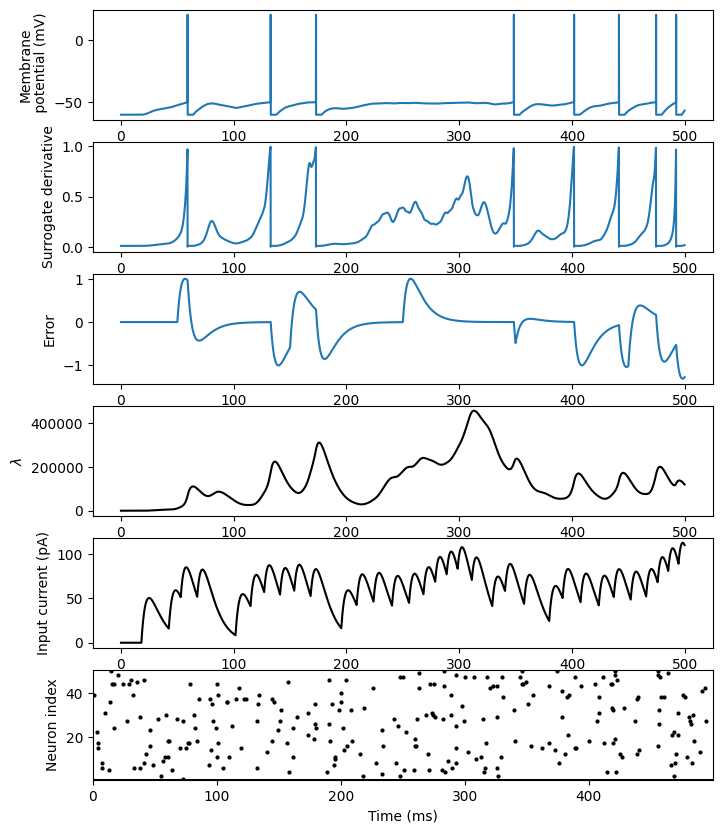

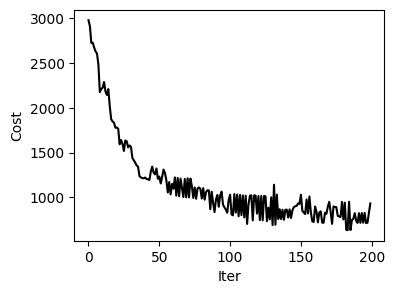

In [13]:
import matplotlib.pyplot as plt
t = np.arange(nt)*dt*1e3
plt.figure(figsize=(8, 10))
plt.subplot(6,1,1)
plt.plot(t, voltage_arr[0])
plt.ylabel('Membrane\n potential (mV)')
plt.subplot(6,1,2)

plt.plot(t, et1.surrogate_derivative_fastsigmoid(u=voltage_arr[0]))
plt.ylabel('Surrogate derivative')
plt.subplot(6,1,3)
plt.plot(t, error_arr[0])
plt.ylabel('Error')
plt.subplot(6,1,4)
plt.plot(t, lambda_arr[0, 0], color="k")
plt.ylabel('$\lambda$')
plt.subplot(6,1,5)
plt.plot(t, current_arr[0], color="k")
plt.ylabel('Input current (pA)')
plt.subplot(6,1,6)
for i in range(N_in):
    plt.plot(t, x[:, i]*(i+1), 'ko', markersize=2)
plt.xlabel('Time (ms)'); plt.ylabel('Neuron index')
plt.xlim(0, t.max()); plt.ylim(0.5, N_in+0.5)
plt.show()
plt.figure(figsize=(4, 3))
plt.plot(cost_arr, color="k")
plt.xlabel('Iter'); plt.ylabel('Cost')
plt.show()

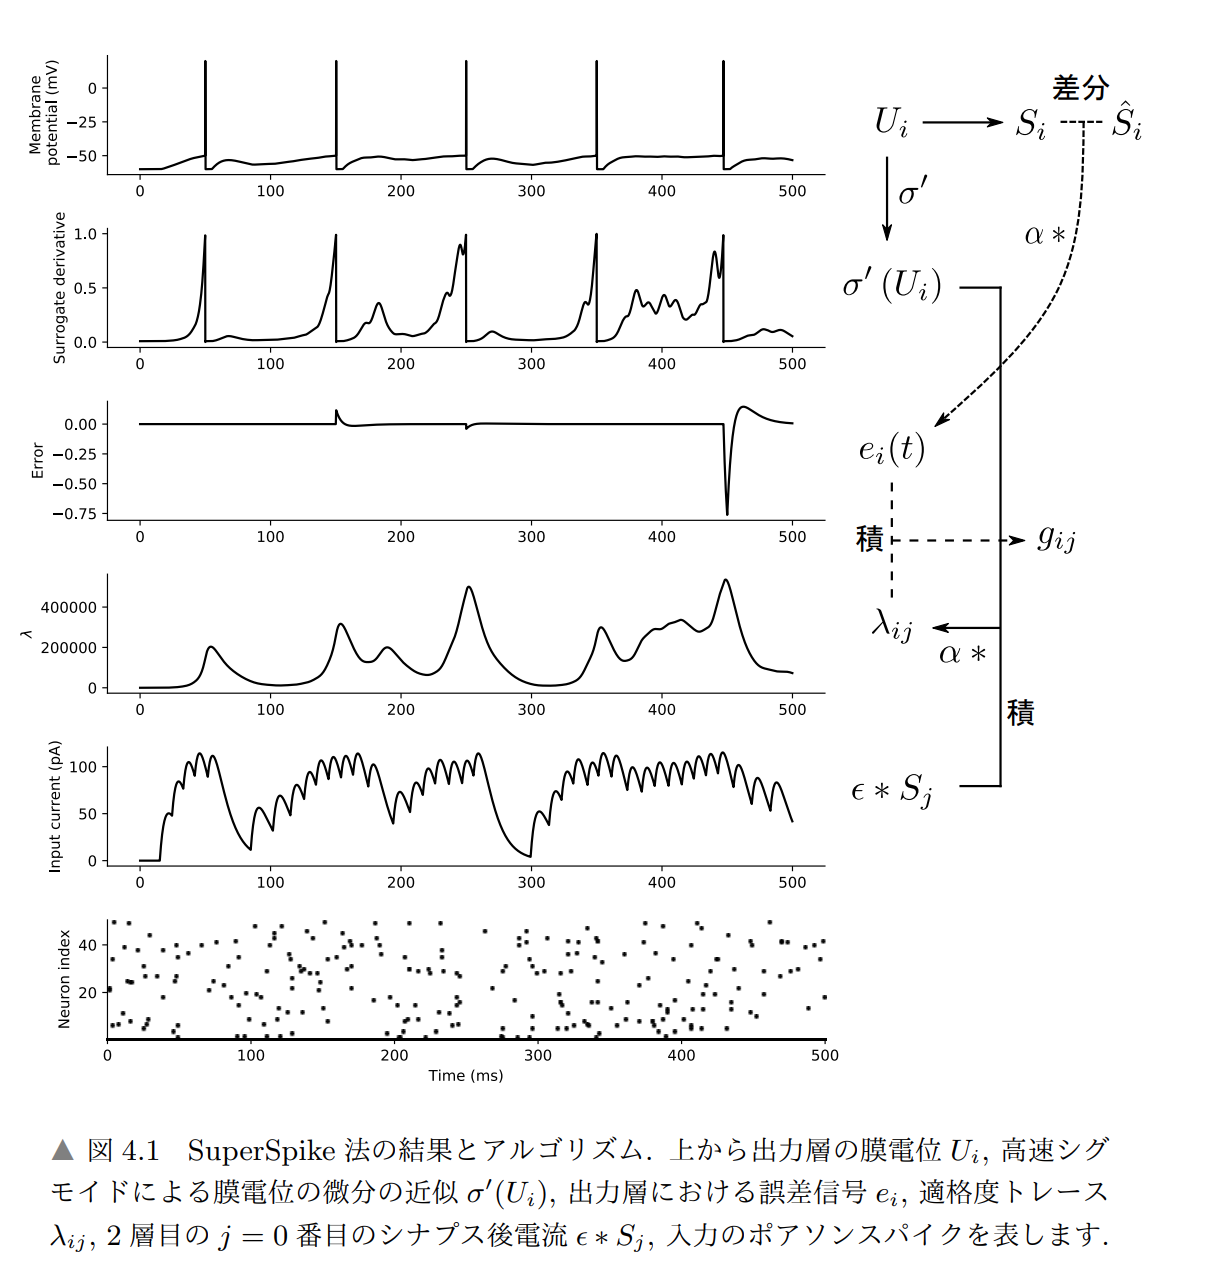

In [22]:
import pytorch
import numpy as np

# Building Spiking Neural Unit
class SNU(pynn.Module):
    """
    Args:
        n_in (int): The number of input.
        n_out (int): The number of output.
        l_tau (floot): Degree of leak (From 0 to 1).
        soft (bool): Change output activation to sigmoid func (True)
                     or Step func. (False)
        rec (bool): Adding recurrent connection or not.
    """
    def __init__(self, n_in, n_out, l_tau=0.8, soft=False,
                 rec=False, nobias=False, initial_bias=None,
                 gpu=False):
        super(SNU, self).__init__()
        initializer = chainer.initializers.GlorotUniform()
        with self.init_scope():
            self.Wx = L.Linear(n_in, n_out, nobias=True, initialW=initializer)
            if rec:
                self.Wy = L.Linear(n_out, n_out, nobias=True)
            
            if nobias:
                self.b = None
            else:
                if initial_bias is None:
                    bias_initializer = initializers.Uniform()
                    self.b = Parameter(bias_initializer, n_out)
                else:                    
                    bias_initializer = initializers._get_initializer(initial_bias)
                    self.b = Parameter(bias_initializer, n_out)
            
            self.n_out = n_out            
            self.l_tau = l_tau
            self.rec = rec
            self.soft = soft
            
            self.gpu = gpu
            
            self.s = None
            self.y = None

    def reset_state(self, s=None, y=None):
        self.s = s
        self.y = y

    def initialize_state(self, shape):
        if self.gpu:
            xp = cuda.cupy
        else:                
            xp = np
        self.s = initializers.generate_array(initializers.Normal(), (shape[0], self.n_out),
                                             xp, dtype=xp.float32)
        self.y = Variable(xp.zeros((shape[0], self.n_out), dtype=xp.float32))
        
    def __call__(self, x):
        if self.s is None:
            self.initialize_state(x.shape)
        
        if self.rec:            
            s = F.elu(self.Wx(x) + self.Wy(self.y) + self.l_tau * self.s * (1 - self.y))
        else:            
            s = F.elu(self.Wx(x) + self.l_tau * self.s * (1 - self.y))
        
        if self.soft:            
            y = F.sigmoid(F.bias(s, self.b))
        else:            
            y = step_func.step(F.bias(s, self.b))
            #y = F.relu(F.sign(F.bias(s, self.b)))
            
        self.s = s
        self.y = y
        
        return y

In [37]:
main()

Loading datas


100%|██████████████████████████████████████████████████████████████████████████| 60000/60000 [00:10<00:00, 5599.03it/s]


Building model


NameError: name 'network' is not defined